<a href="https://colab.research.google.com/github/Hramchenko/HTR/blob/master/HTRTrainCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
        

In [0]:
import sys
sys.path.append("./HTR/")
from IAMWords import IAMWords


pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=7)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=7)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
from ArtificialHandwritting import ArtificialHandwritting
artificial_data = ArtificialHandwritting(batch_size, "./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

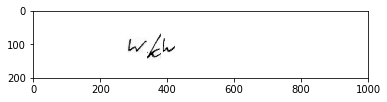

torch.Size([100, 200, 1000])

In [0]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from Layers import *
from HTREncoder import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:
class FCDecoder(nn.Module):
  def __init__(self):
    super(FCDecoder, self).__init__()
    encoded_width = 122
    encoded_height = 64
    encoded_size = encoded_width*encoded_height
    symbols_count = len(train_set.codes)
    from math import floor
    self.fc = FullyConnectedX([encoded_size, floor(encoded_size*0.7)], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.LeakyReLU(0.2))
    self.fc2 = FullyConnectedX([floor(encoded_size*0.7), floor(encoded_size*0.3), symbols_count], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
    self.bn = nn.BatchNorm1d(floor(encoded_size*0.7))
    
  def forward(self, x):
    x = self.fc(x)
    x = self.bn(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x



In [0]:
encoder_fc = FCDecoder().to(device)
cnn_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
fc_optimizer = optim.Adam(encoder_fc.parameters(), lr=1e-4, weight_decay=0.00005)
criterion = nn.NLLLoss()
randx = 900

In [0]:
recognition_result = torch.LongTensor(batch_size, 1).to(device)

for i in range(0, 2000):
    data, target = artificial_data.make_random_batch(1, randx)
    data = data.unsqueeze(1).to(device)
    target = target.to(device)
    cnn_optimizer.zero_grad()
    fc_optimizer.zero_grad()
    enc = encoder(data)
    enc = enc.flatten(start_dim=1)
    symb = encoder_fc(enc)
    loss = criterion(symb, target[:, 0])
    if i % 50 == 0:
      recognition_result[:,0] = symb.topk(1, dim=1)[1].flatten().detach()
      for i in range(0, 5):
        t = test_set.decode_word(target[i,:])
        r = test_set.decode_word(recognition_result[i,:])
        print(t + "->" + r)
      print(loss.item())
    loss.backward()
    cnn_optimizer.step()
    fc_optimizer.step()

f->q
q->q
a->a
r->r
b->b
2.6310861110687256
h->h
m->m
h->u
e->e
b->b
2.622636079788208
g->g
z->z
v->y
k->k
l->t
2.6252410411834717
m->w
m->m
w->h
k->h
z->z
2.629223108291626
h->h
q->q
w->h
f->f
y->w
2.6085665225982666
h->u
j->j
c->e
l->l
b->b
2.6162166595458984
g->g
v->v
g->g
c->e
d->d
2.5939812660217285
d->d
x->s
p->p
h->h
z->z
2.598590612411499
g->d
d->d
k->h
k->h
o->o
2.6026787757873535
w->w
q->d
r->r
c->e
u->h
2.5790352821350098
p->g
h->h
q->q
z->z
v->v
2.597132921218872
z->z
f->l
h->h
z->z
h->h
2.553447961807251
t->l
p->p
p->p
z->z
v->v
2.541186571121216
e->e
b->b
x->x
a->a
k->h
2.5517826080322266
c->c
a->a
w->w
p->p
k->h
2.579864501953125
e->e
g->g
o->o
h->h
x->x
2.5378713607788086
i->i
i->i
l->l
j->j
i->i
2.5448856353759766
k->k
n->x
q->q
o->o
c->c
2.5445191860198975
i->i
f->f
g->g
h->h
r->s
2.540536403656006
c->e
w->w
w->w
w->h
v->y
2.5518453121185303


In [0]:
def save_cnn(file_name):
  state_dict = {
        "encoder": encoder.state_dict()
      }
  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)
save_cnn("/gdrive/My Drive/cnn.tar")

Network saved: /gdrive/My Drive/cnn.tar
